<h1><center>Starmap port to python</center></h1>

This notebook demonstrates the starmap port to python (starmap.py). It uses the Domain2D helper structures from util.py for discretization.

The lattice example from the starmap code (starmap_ex_lattice.m) is reproduced and the solver is run for the problem. The results are validated against the solution from the starmap code. This way the correctness of the port has been validated (for moments up to P13).

The last part of the notebook deals with reconstructing the radiance field from the solution provided by the solver. The radiance field coefficients $L^{lm}$ are retrieved at the cell centers by first interpolating the staggered grids onto the cell centers, followed by application of $S^{-1}$, which turns the real valued solution for moments $m>0$ into complex valued spherical harmonics coefficients from which the radiance field can be reconstructed. An interactive widget allows to inspect the radiance field at arbitrary locations in the domain.

Additional notes:

- Currently, the support for anisotropic (angle-dependent) phase function is missing. The lattice example uses an isotropic phase function.
- In our derivation (see spherical_harmonics_method.ipynb), we noticed that our radiance field expansion is given in terms of complex SH basis functions $Y^{lm}$, and not their complex conjugate counterparts, as shown in the starmap paper (see middle of p.4). Our reconstruction here uses $Y^{lm}$ and appears to work fine, therefore indicating a typo in the paper.
- In our derivation, we also noticed that the factor $\lambda_l$ from the convolution expressed in SH coefficient multiplication may be missing. In order to be consistent with the results from the matlab code, the python implementation doesn't use this factor as well.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.io
import os
from util import *
from starmap import *

## Problem definition and running the solver

In [2]:
# define problem ---
def source( x, y ):
    if x > 3.0 and x < 4.0 and y > 3.0 and y < 4.0:
        return 1.0
    return 0.0

def sigma_a( x, y ):
    cx = np.ceil(x)
    cy = np.ceil(y)
    g = 0
    if np.ceil((x+y)/2.0)*2.0 == (cx+cy) and cx > 1.0 and cx < 7.0 and cy > 1.0 and cy-2.0*np.abs(cx-4.0) < 4:
        g = 1
    return (1.0-g)*0 + g*10

def sigma_s( x, y ):
    cx = np.ceil(x)
    cy = np.ceil(y)
    g = 0
    if np.ceil((x+y)/2.0)*2.0 == (cx+cy) and cx > 1.0 and cx < 7.0 and cy > 1.0 and cy-2.0*np.abs(cx-4.0) < 4:
        g = 1
    return (1.0-g)*1 + g*0

#setup solver ---
N = 3 # truncation order
res = 250
domain = Domain2D(7.0, res)
solver = Starmap2D( order = N, domain = domain)

#run solver ---
dt = 0.01609501
numTimeSteps = 200
u = solver.run(dt, numTimeSteps, sigma_a, sigma_s, source)

## Validation against results from matlab

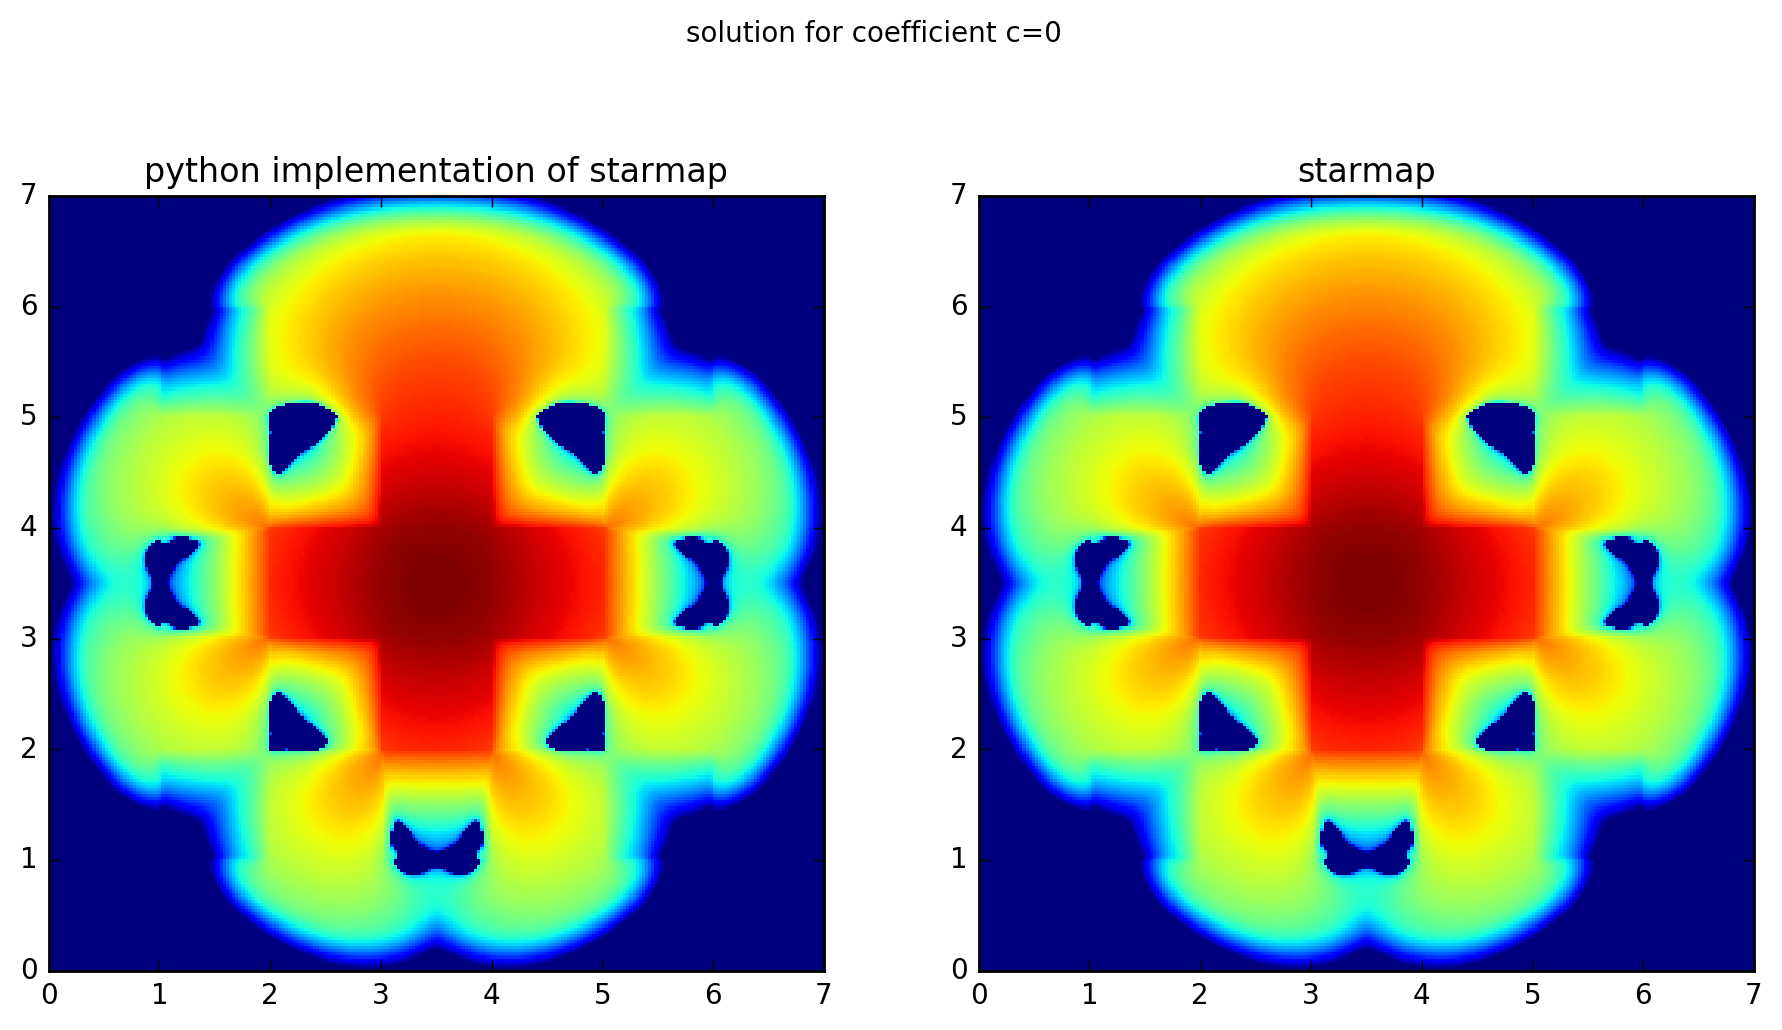

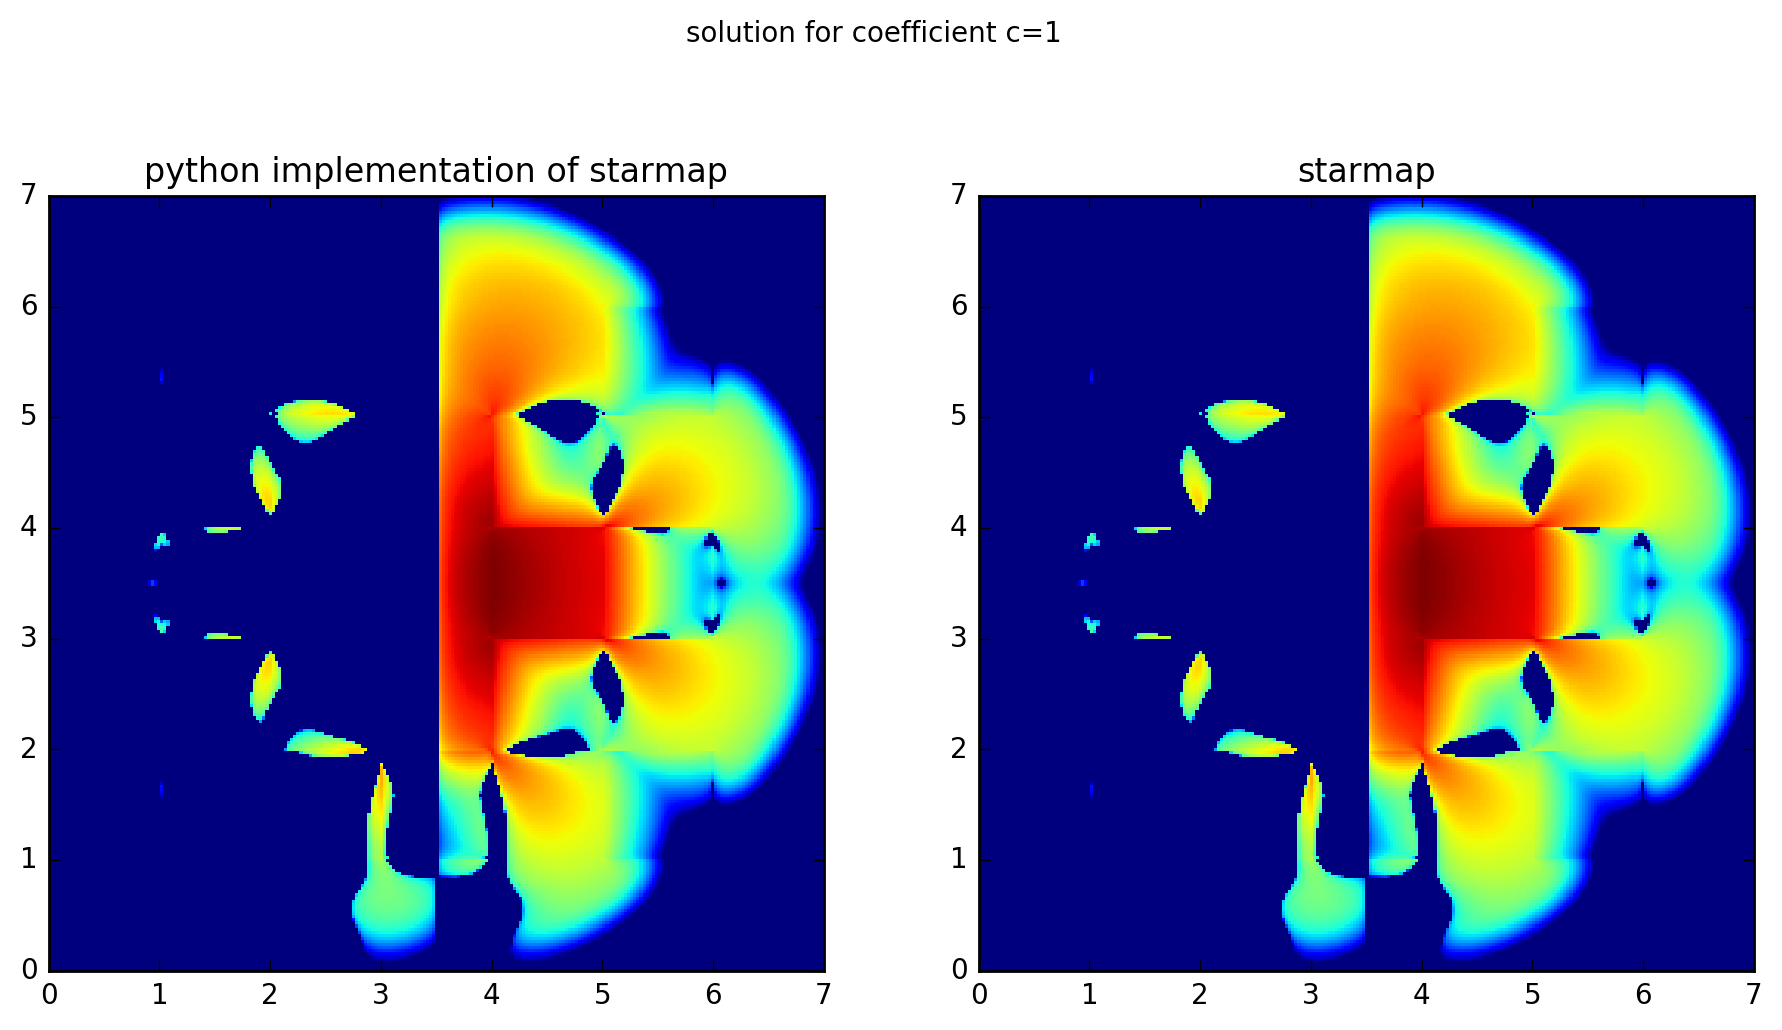

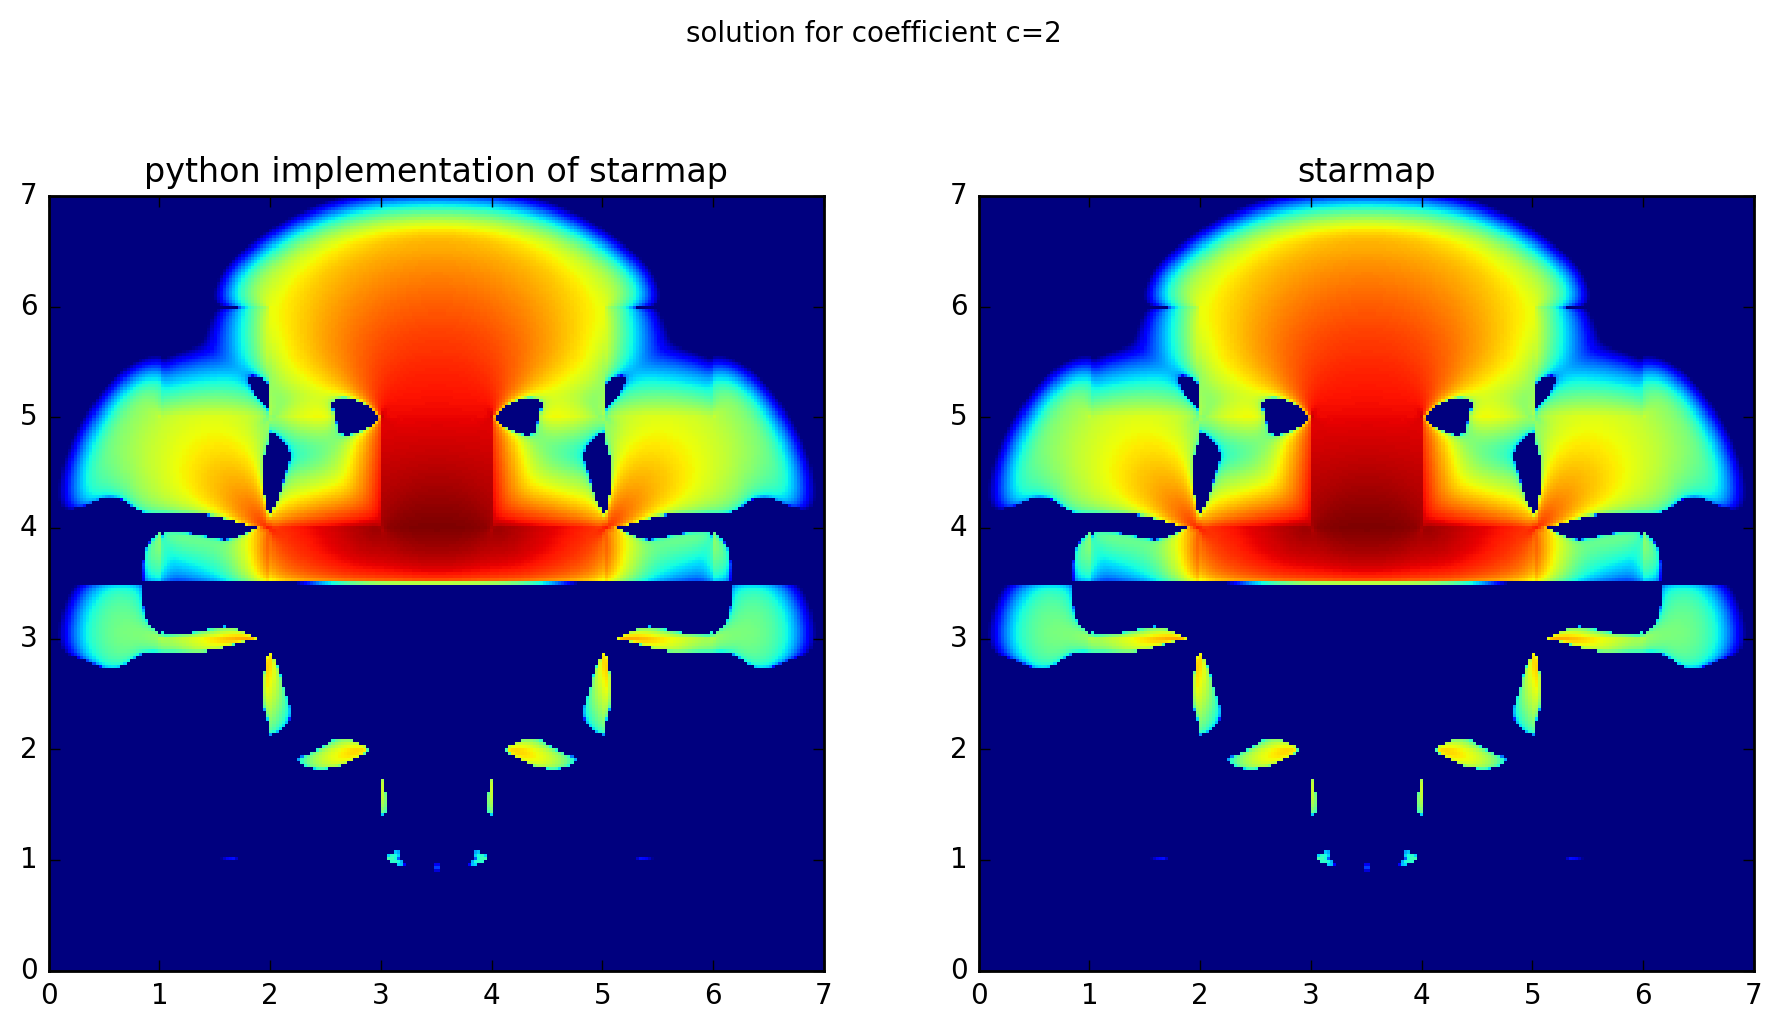

In [3]:
# load solution from starmap solver for validation
solv_U = scipy.io.loadmat("C:/projects/epfl/doc/to_read/PN/codes/starmap/starmap/base.mat")["solv_U"]

# plot a couple of real valued components
for c in range(3):
    starmap_U = solv_U[0, c]
    our_u = u[c]

    starmap_U[starmap_U <= 1.0e-20] = 1.0e-20
    our_u[our_u <= 1.0e-20] = 1.0e-20
    vmin = 1.0e-8
    vmax = np.max(our_u)

    fig = plt.figure(figsize=(11, 11))
    plt.subplot(221)
    plt.title('python implementation of starmap')
    plt.imshow(our_u.T, interpolation="nearest", cmap='jet', norm=LogNorm(vmin=vmin, vmax=vmax), origin='lower', extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
    plt.subplot(222)
    plt.title('starmap')
    plt.imshow(starmap_U.T, interpolation="nearest", cmap='jet', norm=LogNorm(vmin=vmin, vmax=vmax), origin='lower', extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
    plt.suptitle('solution for coefficient c={}'.format(c)); 
    plt.show()

## Reconstructing radiance field from solution

In [4]:
# convert solution to final coefficients at the cell centers
L_lm = solver.compute_sh_coefficients_at_cell_centers(u)

def L_2D( L_lm, order, theta, phi ):
    '''this function will compute the radiance field for a given direction from given sh coefficients'''
    # theta is the polar angle. phi is the azimuthal angle
    result = 0.0
    count = 0
    for l in range(0, order+1):
        for m in range(-l, l+1):
            # in 2D, we skip coefficients for which l+m is odd
            if (l+m) % 2 != 0:
                continue
            # NP: note the swapped angles. This is because in scipy, theta is the azimuthal angle
            coeff = L_lm[count]
            sh = scipy.special.sph_harm(m, l, phi, theta)
            #print( "l={} m={} theta={} phi={} coeff={} sh={}".format(l, m, theta, phi, coeff, sh) )
            result += coeff*sh
            count += 1
    return np.real(result)

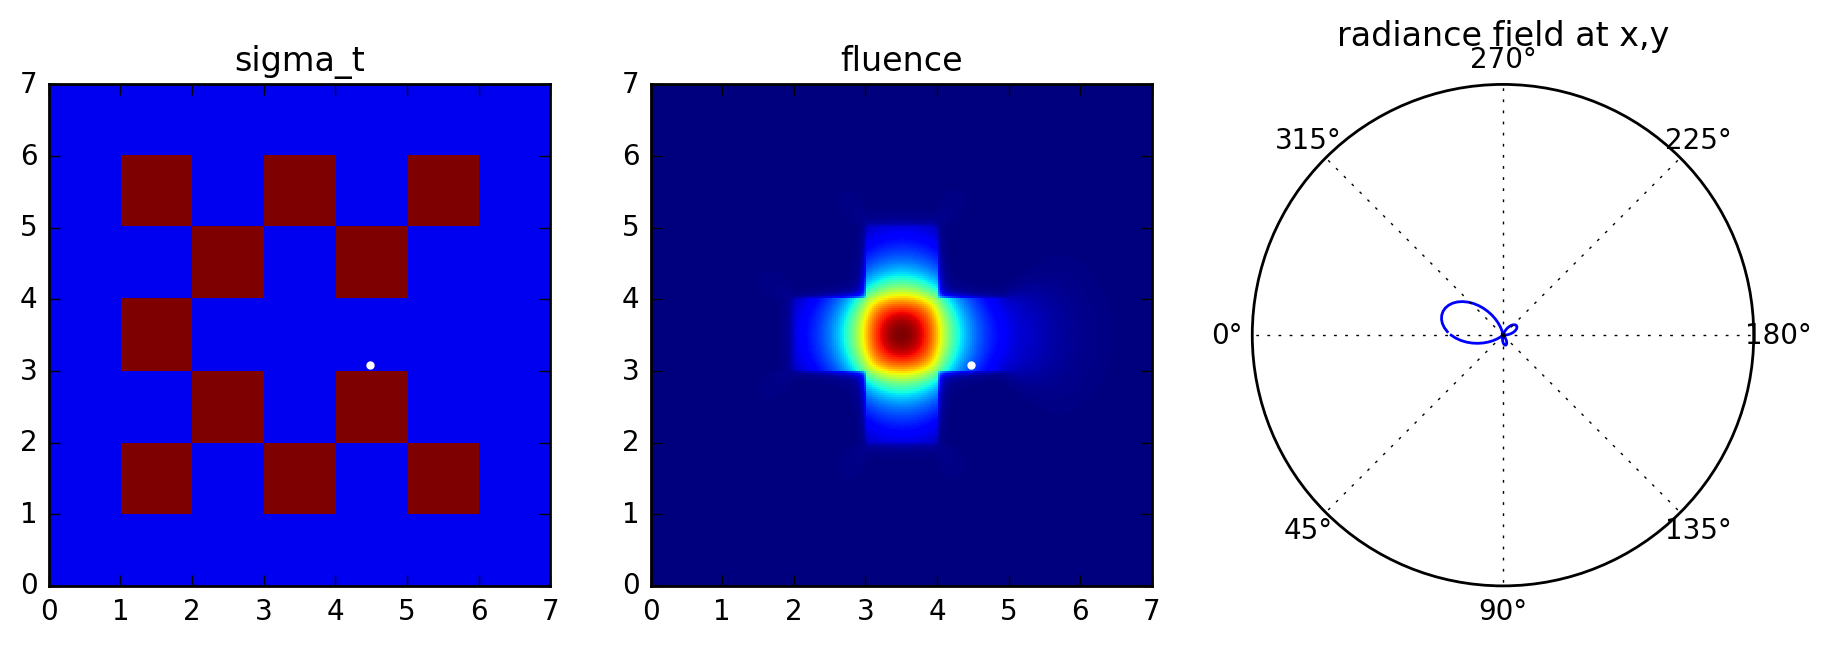

In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(x, y):
    pVS = np.array([x, y])
    pWS = domain.localToWorld(pVS)
    (i,j) = domain.worldToIndex(pWS)
    phi_list = np.arange(0.0, 1.0, 0.01)*2.0*np.pi
    r_list = np.array([L_2D( L_lm[:,i, j], solver.N, np.pi*0.5, phi ) for phi in phi_list])


    # now plot stuff
    fig = plt.figure(figsize=(11, 11))
    
    ax = plt.subplot(131)
    plt.title('sigma_t')
    plt.imshow(solver.solve['st'][0][0], interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(solver.solve['st'][0][0]), extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
    ax.plot( pWS[1], pWS[0], color='w', marker='.', markersize=5, zorder=2 )
    
    ax = plt.subplot(132)
    plt.title('fluence')
    plt.imshow(u[0], interpolation="nearest", cmap='jet', vmin=0.0, vmax=np.max(u[0]), extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])
    ax.plot( pWS[1], pWS[0], color='w', marker='.', markersize=5, zorder=2 )

    ax = plt.subplot(133, projection='polar')
    plt.title('radiance field at x,y')
    ax.plot(phi_list, r_list)
    ax.set_rlim(0,np.max(L_lm[0]))
    ax.set_rticks([]) 
    ax.set_theta_zero_location("W")
    #ax.spines['polar'].set_visible(False)
    #ax.grid(True)
    #ax.set_title("A line plot on a polar axis", va='bottom')
    plt.show()
   

x_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=.5)
y_widget = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=.5)

interact(f,x=x_widget, y=y_widget);
